In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h_transport_materials as htm
from labellines import labelLines

mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False

In [2]:
htm.ureg.define('fraction = [] = frac')
htm.ureg.define('ppm = 1e-6 fraction')

MOLAR_VOL_RT = 24.45 * htm.ureg.L * htm.ureg.mol**-1
MOLAR_MASS_H2 = 2.016 * htm.ureg.g * htm.ureg.mol**-1

def downstream_flux(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): salt permeability
        L (float): salt thickness
        D (float): diffusivity of H in the salt

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up * permeability / L * (2*summation + 1)


def sweep_gas_concentration(flux, area, gas_flow):
    return flux*area/gas_flow*MOLAR_MASS_H2

def concentration_to_ppm(concentration, molar_mass_species, molar_volume_gas):
    return (concentration * molar_volume_gas / molar_mass_species)


This is the design of HYPERION 6/16/2023

<img width="500" alt="image" src="https://github.com/RemDelaporteMathurin/hyperion/assets/40028739/7772f7ec-649a-4a0b-8e58-9cf053cbdbe2">

In [3]:
sweep_rate = 20 * htm.ureg.cm**3 * htm.ureg.min**-1
L = 0.31*htm.ureg.inches
diam = 3.07*htm.ureg.inches
area = np.pi * (diam/2) ** 2
membrane_thickness = 0.08 * htm.ureg.inches

temperature_range = [760, 970] * htm.ureg.K

In [4]:
properties = {
    "flinak": {"diffusivity": htm.diffusivities.filter(material=htm.FLINAK, author='fukada')[0], "solubility": htm.solubilities.filter(material=htm.FLINAK, author='fukada')[0]},
    "flibe": {"diffusivity": htm.diffusivities.filter(material=htm.FLIBE, author='calderoni')[0], "solubility": htm.solubilities.filter(material=htm.FLIBE, author='calderoni')[0]},
    "nickel": {"diffusivity": htm.diffusivities.filter(material=htm.NICKEL).mean(), "solubility": htm.solubilities.filter(material=htm.NICKEL).mean()}
}
for mat, props in properties.items():
    if "permeability" not in props:
        props["permeability"] = props["diffusivity"] * props["solubility"]

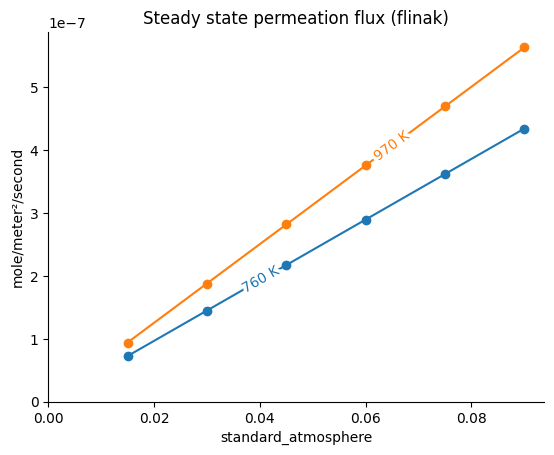

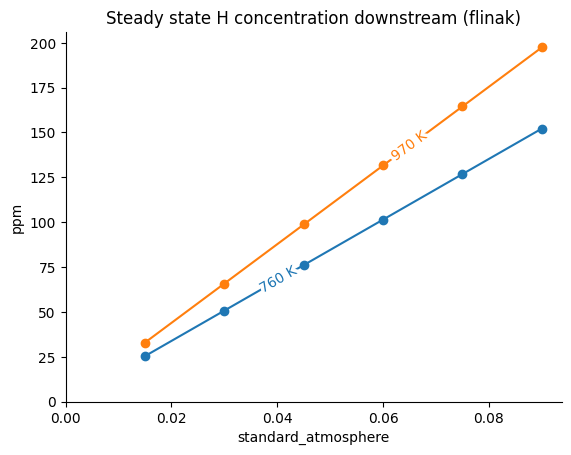

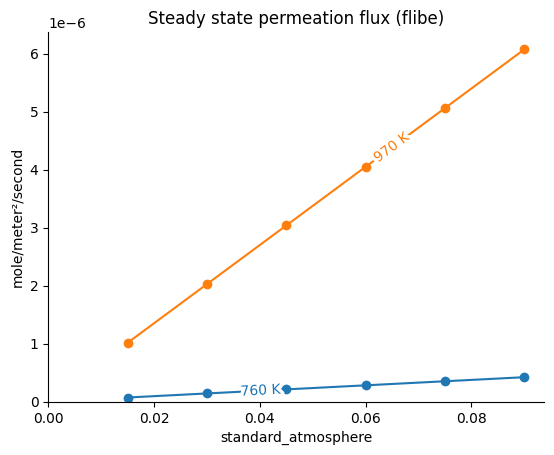

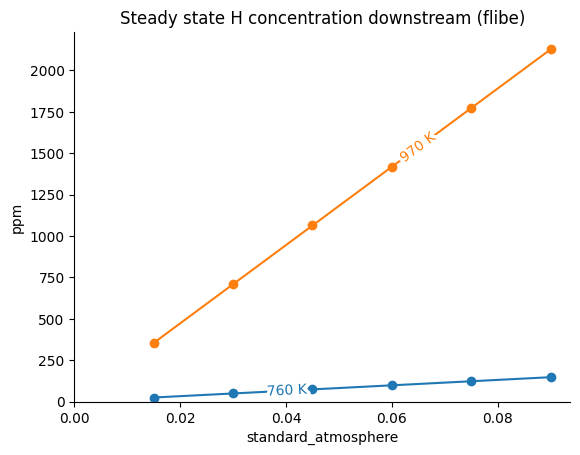

In [5]:
t_array = np.linspace(0, 6, num=500) * htm.ureg.h

total_cylinder_pressure = np.linspace(0.5, 3, num=6) * htm.ureg.atm # Represents pure hydrogen gas
pressures = total_cylinder_pressure * 0.03 # Represents the 3% hydrogen mixture

def steady_state_permeation_flux(pressures, permeability, diffusivity, thickness):
    fluxes=[]

    for P_up in pressures:
        flux = downstream_flux(t_array, P_up, permeability, thickness, diffusivity)[-1]
        fluxes.append(flux)
    fluxes = htm.ureg.Quantity.from_list(fluxes)
    return fluxes

def plot_steady_state_permeation_flux(pressures, permeability, diffusivity, thickness, **kwargs):
    fluxes = steady_state_permeation_flux(pressures, permeability, diffusivity, thickness)
    return plt.plot(pressures, fluxes, **kwargs)

def plot_steady_state_gas_concentration(pressures, permeability, diffusivity, thickness, **kwargs):
    fluxes = steady_state_permeation_flux(pressures, permeability, diffusivity, thickness)
    concentrations = []
    for flux in fluxes:
        concentration = sweep_gas_concentration(flux, area, sweep_rate)
        concentration = concentration_to_ppm(concentration, MOLAR_MASS_H2, MOLAR_VOL_RT).to(htm.ureg.ppm)
        concentrations.append(concentration)

    concentrations = htm.ureg.Quantity.from_list(concentrations)

    return plt.plot(pressures, concentrations, **kwargs)

for mat, props in properties.items():
    if mat == "nickel":
        continue
    permeability = props["permeability"]
    diffusivity = props["diffusivity"]
    plt.figure()
    plt.title(f'Steady state permeation flux ({mat})')
    plt.gca().yaxis.set_units(htm.ureg.mol * htm.ureg.m**-2 * htm.ureg.s**-1)
    for T in temperature_range:
        plot_steady_state_permeation_flux(pressures, permeability.value(T), diffusivity.value(T), L, marker="o", label=f"{T: ~P}")
    labelLines(plt.gca().get_lines())
    plt.ylim(bottom=0)
    plt.xlim(left=0)

    plt.figure()
    for T in temperature_range:
        plot_steady_state_gas_concentration(pressures, permeability.value(T), diffusivity.value(T), L, marker="o", label=f"{T: ~P}")
    plt.title(f'Steady state H concentration downstream ({mat})')
    labelLines(plt.gca().get_lines())
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.show()

Text(0.5, 1.0, 'Evolution of the sweep gas concentration \n of H2 at different upstream total pressures \n @ T = 300.0 °C (nickel)')

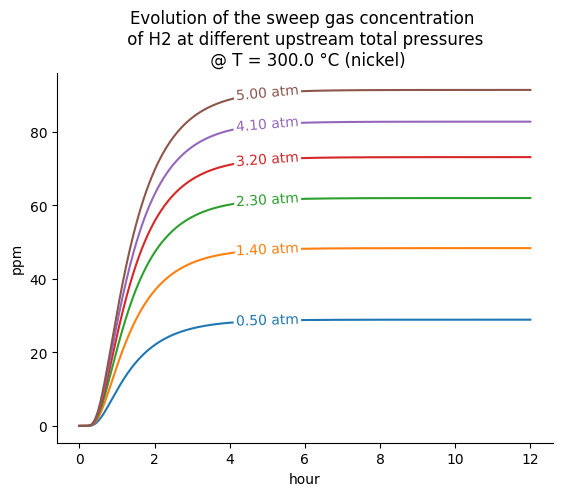

In [14]:
T = htm.ureg.Quantity(300, htm.ureg.degC).to(htm.ureg.K)
t_array = np.linspace(0, 12, num=500) * htm.ureg.h

total_pressure = np.linspace(0.5, 5, num=6) * htm.ureg.atm # total pressure

permeability = properties["nickel"]["permeability"]
diffusivity = properties["nickel"]["diffusivity"]

def downstream_flux_metal(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): salt permeability
        L (float): salt thickness
        D (float): diffusivity of H in the salt

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up**0.5 * permeability / L * (2*summation + 1)

plt.figure()
fluxes=[]
concentrations = []
for P_tot in total_pressure:
    partial_pressure = P_tot * 0.03
    flux = downstream_flux_metal(t_array, partial_pressure, permeability.value(T), membrane_thickness, diffusivity.value(T))
    concentration = sweep_gas_concentration(flux, area, sweep_rate)
    concentration = concentration_to_ppm(concentration, MOLAR_MASS_H2, MOLAR_VOL_RT).to(htm.ureg.ppm)
    concentration[0] = 0
    plt.plot(t_array, concentration, label=f"{P_tot:~.2fP}")
labelLines(plt.gca().get_lines(), xvals=[5] * 6)
plt.title(f"Evolution of the sweep gas concentration \n of H2 at different upstream total pressures \n @ T = {T.to(htm.ureg.degC):~P} ({mat})")

DimensionalityError: Cannot convert from 'inch * liter * minute * particle * standard_atmosphere / centimeter ** 3 / meter / mole / pascal ** 0.5 / second' ([mass] ** 0.5 / [length] ** 0.5 / [time]) to 'ppm' (dimensionless)

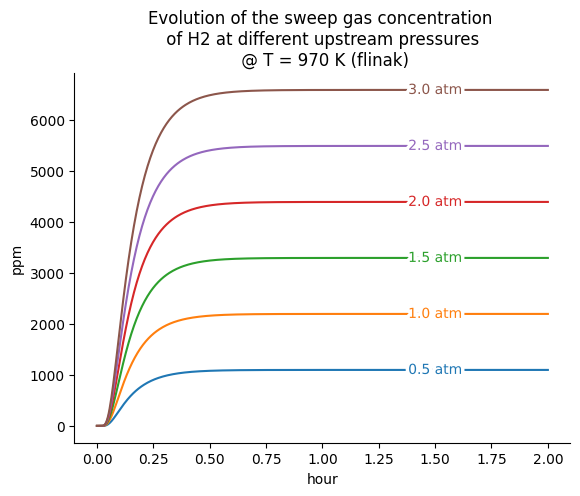

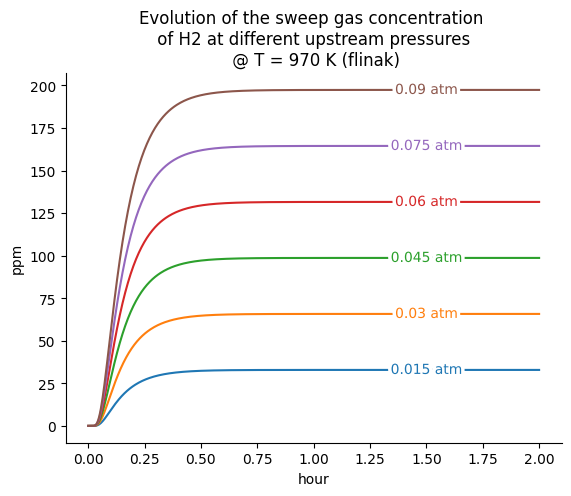

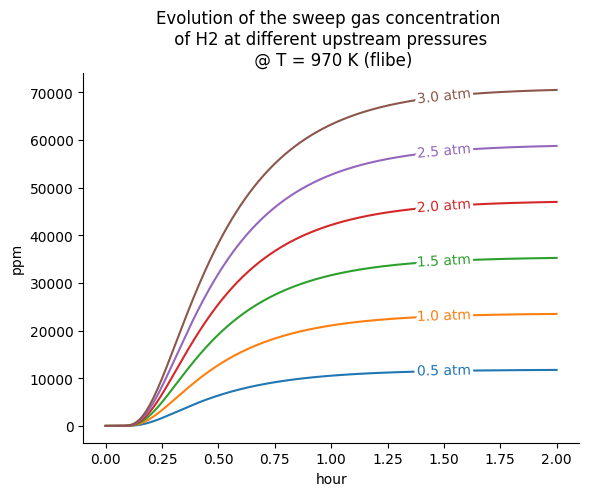

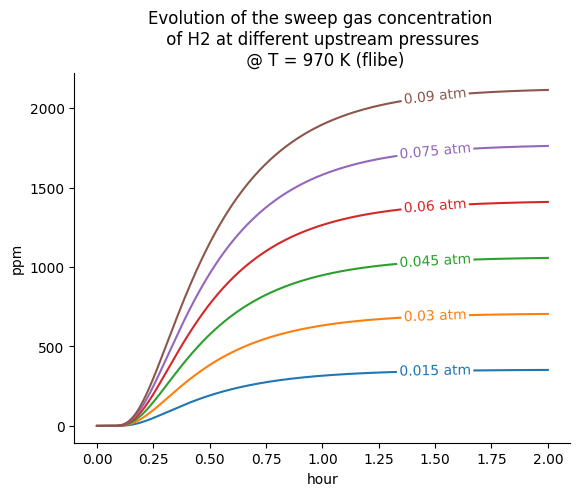

<Figure size 640x480 with 0 Axes>

In [ ]:
T = temperature_range[1]
t_array = np.linspace(0, 2, num=500) * htm.ureg.h

higher_pressures = np.linspace(0.5, 3, num=6) * htm.ureg.atm # Represents pure hydrogen gas
lower_pressures = higher_pressures * 0.03 # Represents the 3% hydrogen mixture

for mat, props in properties.items():
    if mat == "nickel":
        continue
    permeability = props["permeability"]
    diffusivity = props["diffusivity"]

    for pressures in [higher_pressures, lower_pressures]:
        plt.figure()
        fluxes=[]
        concentrations = []
        for P_up in pressures:
            flux = downstream_flux(t_array, P_up, permeability.value(T), L, diffusivity.value(T))
            concentration = sweep_gas_concentration(flux, area, sweep_rate)
            concentration = concentration_to_ppm(concentration, MOLAR_MASS_H2, MOLAR_VOL_RT).to(htm.ureg.ppm)
            concentration[0] = 0
            plt.plot(t_array, concentration, label=f"{P_up:~P}")
        labelLines(plt.gca().get_lines(), xvals=[1.5] * 6)
        plt.title(f"Evolution of the sweep gas concentration \n of H2 at different upstream pressures \n @ T = {T:~P} ({mat})")

Let's have a look at the approximation of neglecting the nickel membrane.

In [ ]:
def W_number(P_up, D_metal, D_salt, K_metal, K_salt, e_metal, e_salt):
    c_0 = metal_surface_concentration(K_metal, P_up)
    X = D_salt/e_salt * K_salt / K_metal**2 * e_metal/D_metal * c_0
    return 1 + (1 - (1 + 4 * X)**0.5)/ (2* X)

def metal_surface_concentration(K_metal, P_up):
    return K_metal*P_up**0.5

It is possible to compute the $W$ adimensional number over a range of temperature and pressure.

When $W \ll 1$ then the steady state permeation resistance of the nickel foil is negligible.


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:86: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


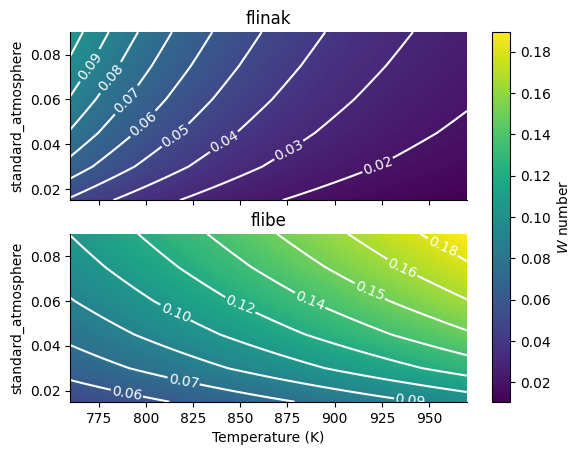

In [ ]:
temperatures = np.linspace(*temperature_range)
XX, YY = np.meshgrid(temperatures, lower_pressures)
D_metal = properties["nickel"]["diffusivity"]
K_metal = properties["nickel"]["solubility"]
e_metal = 0.08 * htm.ureg.inch
e_salt = L

W_values = {}
for mat, props in properties.items():
    if mat == "nickel":
        continue
    D_salt = props["diffusivity"]
    K_salt = props["solubility"]

    W_values[mat] = W_number(YY, D_metal.value(XX), D_salt.value(XX), K_metal.value(XX), K_salt.value(XX), e_metal, e_salt)


vmin = np.min([np.min(W_values[mat]) for mat in properties if mat != "nickel"])
vmax = np.max([np.max(W_values[mat]) for mat in properties if mat != "nickel"])

fig, axs = plt.subplots(2, 1, sharex=True)
for ax, (mat, props) in zip(axs, properties.items()):
    if mat == "nickel":
        continue
    plt.sca(ax)
    plt.title(f"{mat}")
    WW = W_values[mat]
    CF = plt.contourf(XX, YY, WW, levels=100, vmin=vmin, vmax=vmax)
    CF.set_clim(vmin,vmax)
    CS = plt.contour(XX, YY, WW, levels=10, colors="white")
    plt.clabel(CS, fmt="%.2f")

plt.xlabel(f"Temperature ({XX.units:~P})")
from matplotlib.cm import ScalarMappable
plt.colorbar(ScalarMappable(norm=CF.norm, cmap=CF.cmap), ax=axs.ravel().tolist(), label="$W$ number")
plt.show()


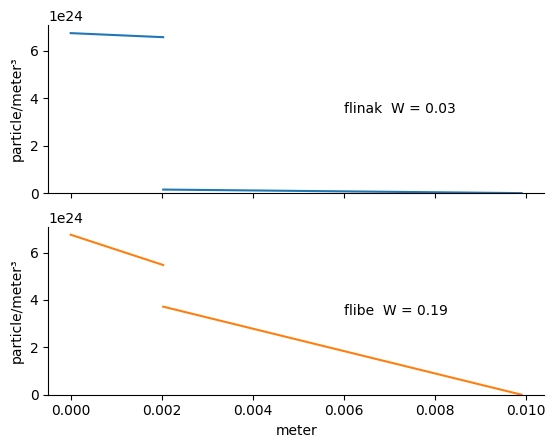

In [ ]:
def flux_metal_only(P_up, D_metal, K_metal, e_metal):
    c0 = metal_surface_concentration(K_metal, P_up)
    return D_metal*c0/e_metal

def c_mi(P_up, D_metal, D_salt, K_metal, K_salt, e_metal, e_salt):
    """Concentration in the metal at the metal_salt interface
    """
    c_0 = metal_surface_concentration(K_metal, P_up)
    A = D_salt/e_salt * K_salt / K_metal**2
    B = D_metal/e_metal
    return (-B + (B**2 + 4*A*B*c_0)**0.5)/(2*A)

def c_si(P_up, D_metal, D_salt, K_metal, K_salt, e_metal, e_salt):
    """Concentration in the salt at the metal_salt interface
    """
    return c_mi(P_up, D_metal, D_salt, K_metal, K_salt, e_metal, e_salt)**2*K_salt/K_metal**2

T = temperature_range[1]
e_metal = 0.08 * htm.ureg.inch
e_salt = L
P_up = 0.09 * htm.ureg.atm

# # Calderoni parameters
# T = htm.ureg.Quantity(700, htm.ureg.degC).to(htm.ureg.K)
# e_metal = 2 * htm.ureg.mm
# e_salt = 8.1 * htm.ureg.mm
# P_up = 1.2e3 * htm.ureg.Pa

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
salt_to_colour = {"flibe": "tab:orange", "flinak": "tab:blue"}

for ax, (mat, props) in zip(axs, properties.items()):
    plt.sca(ax)
    ax.yaxis.set_units(htm.ureg.particle * htm.ureg.m**-3)
    if mat == "nickel":
        continue
    D_salt = props["diffusivity"]
    K_salt = props["solubility"]
    c0 = metal_surface_concentration(K_metal.value(T), P_up)
    concentrations = [
        c0,
        c_mi(P_up, D_metal.value(T), D_salt.value(T), K_metal.value(T), K_salt.value(T), e_metal, e_salt),
        np.nan * htm.ureg.particle * htm.ureg.m**-3,
        c_si(P_up, D_metal.value(T), D_salt.value(T), K_metal.value(T), K_salt.value(T), e_metal, e_salt),
        0 * htm.ureg.particle * htm.ureg.m**-3,
    ]
    x = [0 * htm.ureg.m, e_metal, np.nan * htm.ureg.m, e_metal, e_salt + e_metal]
    x = htm.ureg.Quantity.from_list(x)
    concentrations = htm.ureg.Quantity.from_list(concentrations)
    W = W_number(P_up, D_metal.value(T), D_salt.value(T), K_metal.value(T), K_salt.value(T), e_metal, e_salt)
    plt.annotate(f"{mat}  W = {W:.2f~P}", (0.006 * htm.ureg.m, max(concentrations)/2))
    plt.plot(x, concentrations, color=salt_to_colour[mat])
plt.ylim(bottom=0)
plt.show()